In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["PYTENSOR_FLAGS"] = "compiledir=./pytensor_cache,mode=FAST_COMPILE,optimizer=None"

In [2]:
import numpy as np
import pandas as pd
import yaml
np.random.seed(42)
import os
from resum.polynomial_chaos_expansion import PCEMultiFidelityModel
import matplotlib.pyplot as plt
import arviz as az

Compiledir: compiledir=./pytensor_cache,mode=FAST_COMPILE,optimizer=None


In [3]:
with open("./binary-black-hole/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

version       = config_file["path_settings"]["version"]
path_out_cnp  = config_file["path_settings"]["path_out_cnp"]
path_out_pce = config_file["path_settings"]["path_out_pce"]
file_in=f'{path_out_cnp}/cnp_{version}_output.csv'


In [4]:

if not os.path.exists(path_out_pce):
   os.makedirs(path_out_pce)

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels        = config_file["simulation_settings"]["theta_headers"]
y_label_cnp     = 'y_cnp'
y_err_label_cnp = 'y_cnp_err'
y_label_sim     = 'y_raw'

# Set parameter boundaries
xmin = config_file["simulation_settings"]["theta_min"]
xmax = config_file["simulation_settings"]["theta_max"]
x_fixed = config_file["simulation_settings"]["theta_fixed"]
parameters={}
for i,x in enumerate(x_labels):
   parameters[x]=[xmin[i],xmax[i]]


In [5]:
data=pd.read_csv(file_in)

In [6]:

LF_cnp_noise=np.mean(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
HF_cnp_noise=np.mean(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())

x_train_hf = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy()
y_train_hf = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy()

x_train_mf = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy()
y_train_mf = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][ y_label_cnp].to_numpy()

x_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy()
y_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][ y_label_sim].to_numpy()

x_train_lf = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy()
y_train_lf = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][ y_label_cnp].to_numpy()

In [7]:
# Initialize the model
trainings_data = {
    "lf": [x_train_lf, y_train_lf], 
#    "mf": [x_train_mf, y_train_mf], 
#    "hf": [x_train_hf, y_train_hf]
}

# Prior configurations
priors = {
    "lf": {"sigma_coeffs": 0.3, "sigma": 0.02},
#    "mf": {"sigma_rho": 0.5, "sigma_coeffs_delta": 0.05, "sigma": 0.05},
#    "hf": {"sigma_rho": 0.5, "sigma_coeffs_delta": 0.05, "sigma": 0.05}
}


In [8]:
# Initialize the multi-fidelity model
multi_fidelity_model = None
multi_fidelity_model = PCEMultiFidelityModel(trainings_data, priors, parameters, degree=1)


Data outside [-1,1] detected. Rescaling features...


X range: [-1.         -1.         -0.93805806 -0.94      ] [0.93527508 1.         1.         1.        ]
y_lf std: 0.01912466767809517
Basis stds: [0.         0.5421551  0.57907409 0.569168   0.57298647]


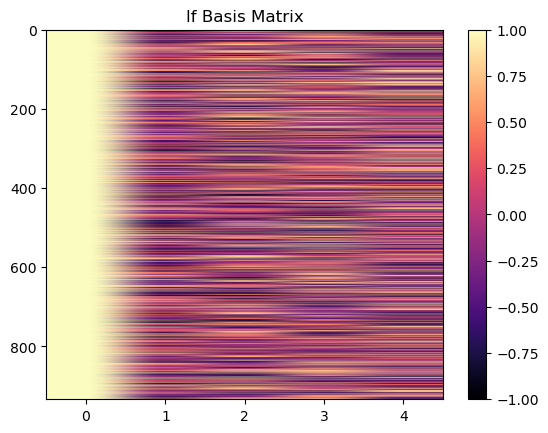

In [9]:
multi_fidelity_model.build_model()
multi_fidelity_model.sanity_check_of_basis()

In [ ]:

trace = multi_fidelity_model.run_inference(method="nuts")
multi_fidelity_model.save_trace(path_out_pce,version)


Output()

/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/resum/lib/python3.10/site-packages/pytensor/tensor/elemwis
e.py:731: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/resum/lib/python3.10/site-packages/pytensor/tensor/elemwis
e.py:731: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


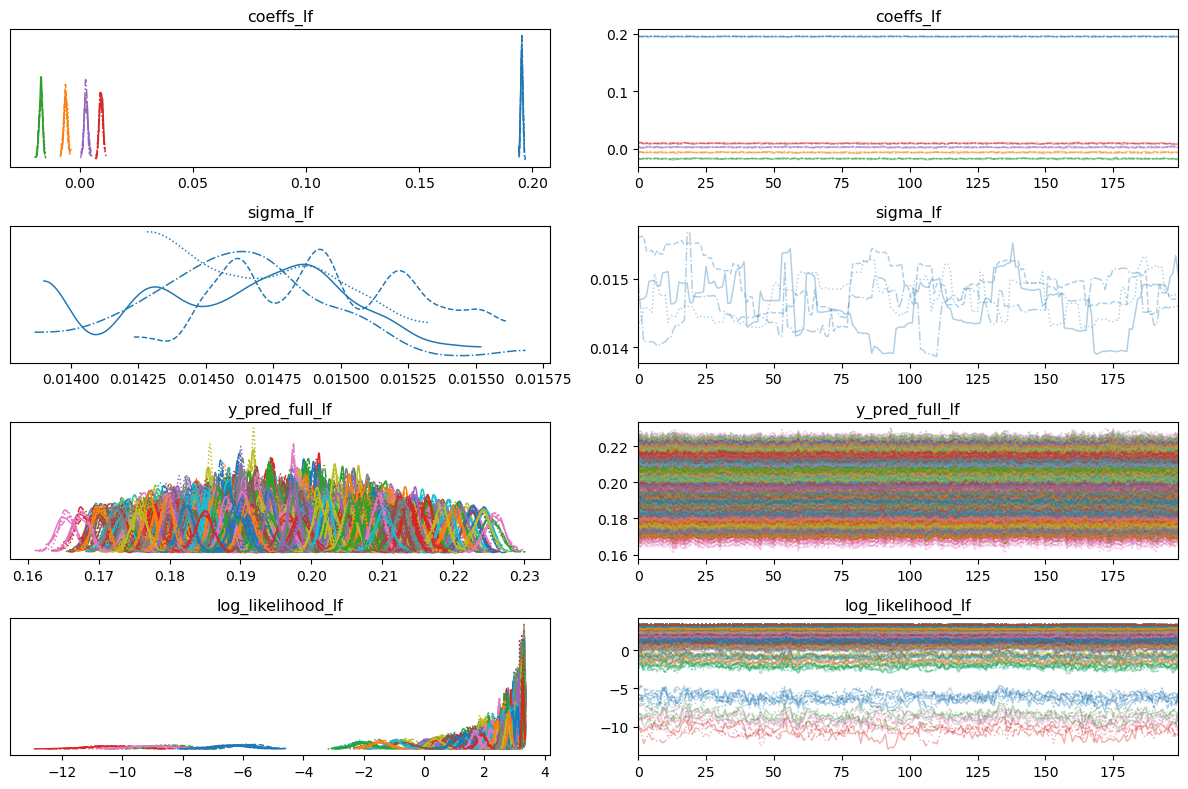

In [13]:
multi_fidelity_model.plot_trace()

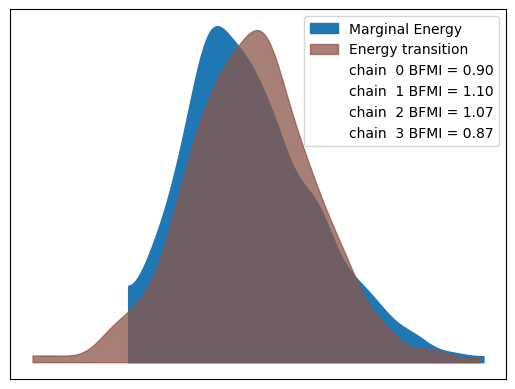

In [14]:
multi_fidelity_model.plot_energy()

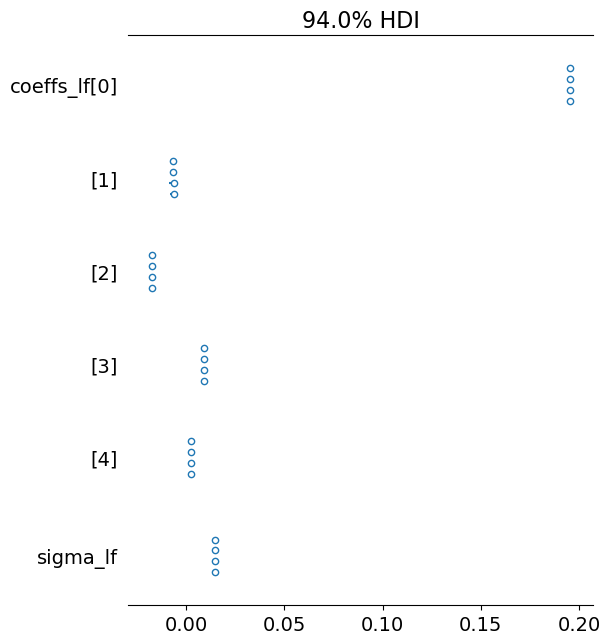

In [15]:
multi_fidelity_model.plot_forrest()

./binary-black-hole/out/pce
